## Intro to fMRI Data Part III The General Linear Model

This is the Python Jupyter Notebook for the third Medium article about the organization and visualization of fMRI data.

First we start with importing the libraries for analysing and visualizing the dataset we downloaded and organized in the [first notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data.ipynb).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

Next we load one of the .csv data files we created in the [first notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data.ipynb). After this we define the scan parameters as discussed in the [second notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data%20Part%20II%20Correlation%20Maps.ipynb), reshape the data to a format that we cna work with and calculate the mean signal intensity for each voxel.

In [27]:
# Import the data for slice 36
data = np.genfromtxt('./fMRI_data/csv_data/slice_36.csv', delimiter=',')

# These are the main parameters of the fMRI scan and experimental desgin
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

x_size = 64
y_size = 64

# Reshape the data
data_ordered = data.reshape(x_size, y_size, acq_num)

# Calculate the mean signal for each voxel
mean_data = data_ordered.mean(axis=2)

In the following we will create a "design matrix" which represents our hypothesis of how the brain responds to the auditory stimulation.

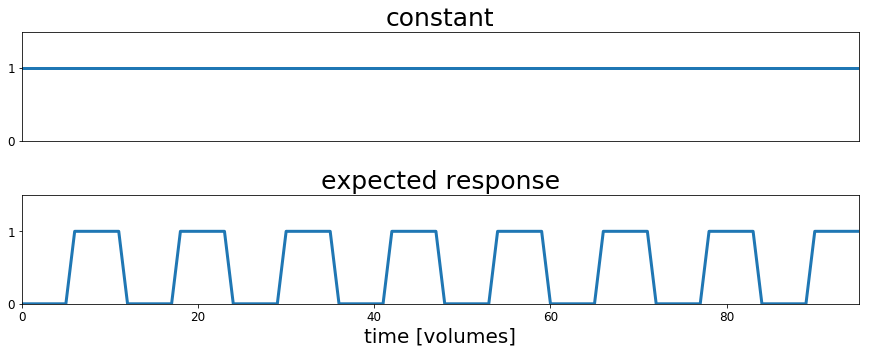

In [28]:
# Create the design matrix
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))

# Create the plots
fig, ax = plt.subplots(2,1, figsize=(15, 5))
ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xlabel('time [volumes]', fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Yes the timecourse looks similar to our assumption but the data has a big offset. Lets normalise so we can visualize it better

PART II GLM

OK a bit noisy but clearly there is a cluster on the right side of the brain where the auditory cortex is located. Coincidence?

So now how can we improve on that. One popular method is to use a Generalized Linear Model (GLM)....

$$y=Xb+e$$

We will use the Ordinary least squares estimator to calculate b
$$b=(X'X)^{-1} X'y$$

Lets first import numpy and matplotlip to visualize our results

We can implement this as follows:

In [31]:
def do_GLM(X, y):
    
    if X.shape[1] > X.shape[0]:
        X = X.transpose()
    
    tmp   = np.linalg.inv(X.transpose().dot(X))
    tmp   = tmp.dot(X.transpose())

    beta  = np.zeros((y.shape[0], X.shape[1]))
    e     = np.zeros(y.shape)
    model = np.zeros(y.shape)
    r     = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        beta[i]  = tmp.dot(y[i,:].transpose())
        model[i] = X.dot(beta[i])
        e[i]     = (y[i,:] - model[i])
        r[i]     = np.sqrt(model[i].var()/y[i,:].var())
    
    return beta, model, e, r

In [32]:
def scale(data):
    return (data - data.min()) / (data.max() - data.min())

Now lets run this and create the maps as we did it for the correlation analysis.

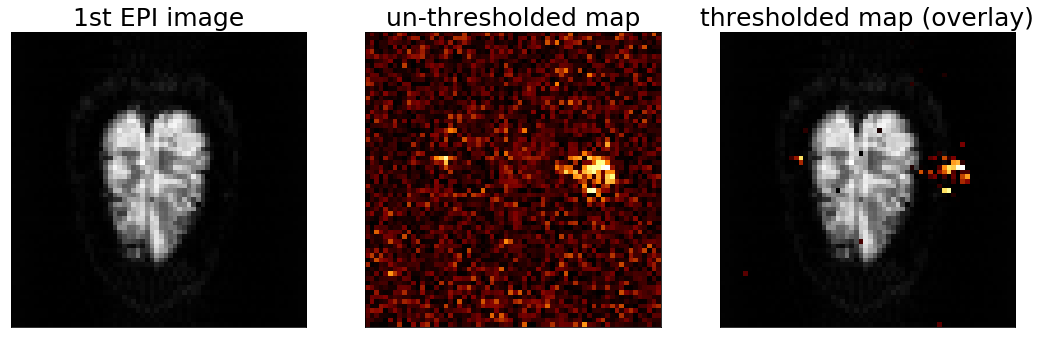

In [33]:
beta, model, e, r = do_GLM(design_matrix, data)

r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.3] = np.nan

fig, ax = plt.subplots(1,3,figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

In [34]:
def z_score(data):
    mean = data.mean(axis=1, keepdims=True)
    std = data.std(axis=1, keepdims=True)
    norm_data = (data-mean)/std
    return norm_data

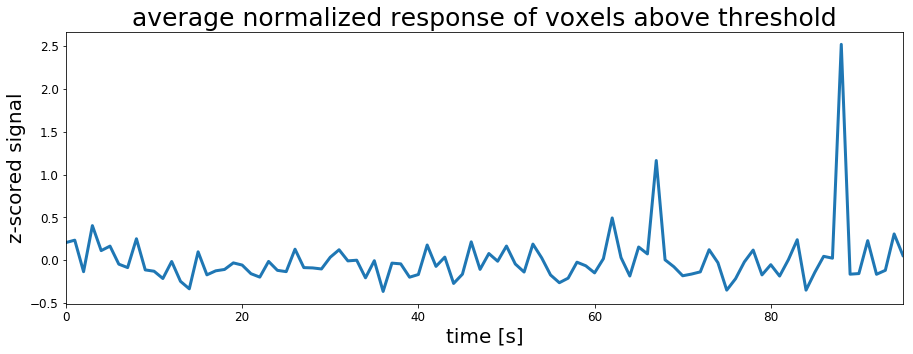

In [35]:
avg = z_score(data_ordered[~np.isnan(map),:])

# and plot the result
fig, ax = plt.subplots(1,1,figsize=(15, 5))

ax.plot(np.transpose(avg).mean(axis=1), lw=3)
ax.set_title('average normalized response of voxels above threshold', fontsize=25)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('z-scored signal', fontsize=20)
ax.tick_params(labelsize=12)

plt.show()

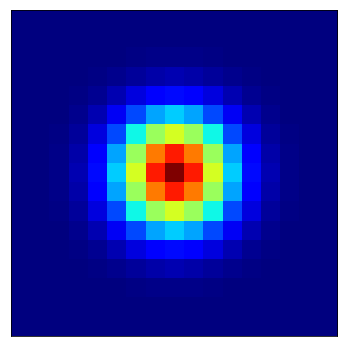

In [36]:
# TAKEN FROM: http://subsurfwiki.org/wiki/Gaussian_filter

import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(8)

fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(gaussian_kernel_array, cmap='jet', interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [37]:
# Adapted from: http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html

def conv_image(image, input_kernel):
    # Flip the kernel
    kernel = np.flipud(np.fliplr(input_kernel))    
    
    # Create output array
    output = np.zeros_like(image)            
    
    # Determine size parameters
    m, n = kernel.shape[0]-1, kernel.shape[1]-1
    M, N = int((m/2)), int((n/2))
    
    # Add zero padding to the input image
    image_padded = np.zeros((image.shape[0] + m, image.shape[1] + n))   
    image_padded[M:-M, N:-N] = image
    
    for x in range(image.shape[1]):     # Loop over every pixel of the image
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            
            output[y,x]=(kernel*image_padded[y:y +m+1, x:x +n+1]).sum() 
            #output[y,x]=(kernel*image_padded[y:y +m+1, x:x +n+1]).mean() 
    return output

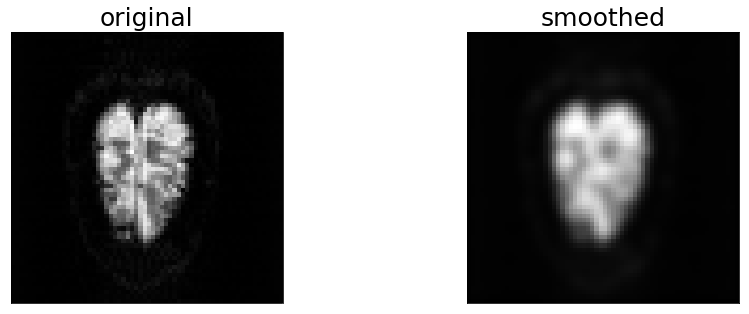

In [38]:
gaussian_kernel_array = gaussian_kernel(3)
smoothed_mean_data = conv_image(mean_data, gaussian_kernel_array)


#plt.imshow(smoothed_mean_data, cmap='gray')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('original', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(smoothed_mean_data, cmap='gray')
ax[1].set_title('smoothed', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.show()

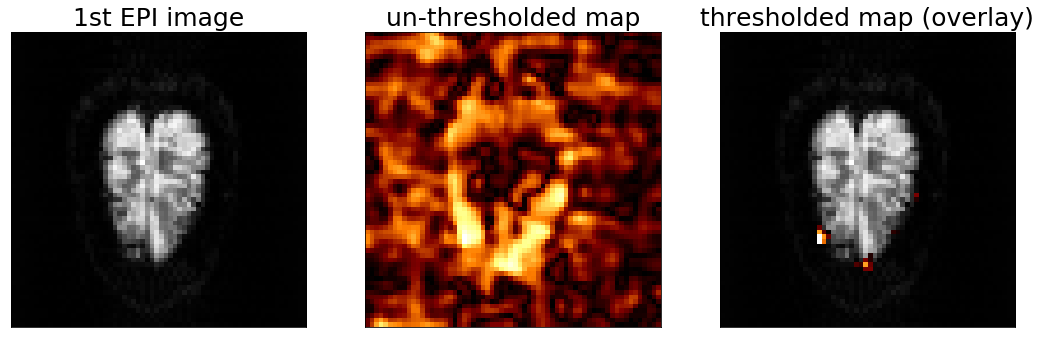

In [39]:
gaussian_kernel_array = gaussian_kernel(3)

data_smoothed = np.zeros_like(data_ordered)
for i in range(data_ordered.shape[2]):
    data_smoothed[:,:,i] = conv_image(data_ordered[:,:,i], gaussian_kernel_array)
    
data_smoothed = data_smoothed.reshape(x_size * y_size, acq_num)
beta, model, e, r = do_GLM(design_matrix, data_smoothed)

r = r.reshape(x_size,y_size)
map = r.copy()
map[map<0.35] = np.nan

fig, ax = plt.subplots(1,3,figsize=(18, 6))

ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('1st EPI image', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(r, cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

Finaly lets calculate and plot the maos for multiple slices...

C:\Users\Carsten\Anaconda3\lib\site-packages\matplotlib\colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\Carsten\Anaconda3\lib\site-packages\numpy\ma\core.py:710: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


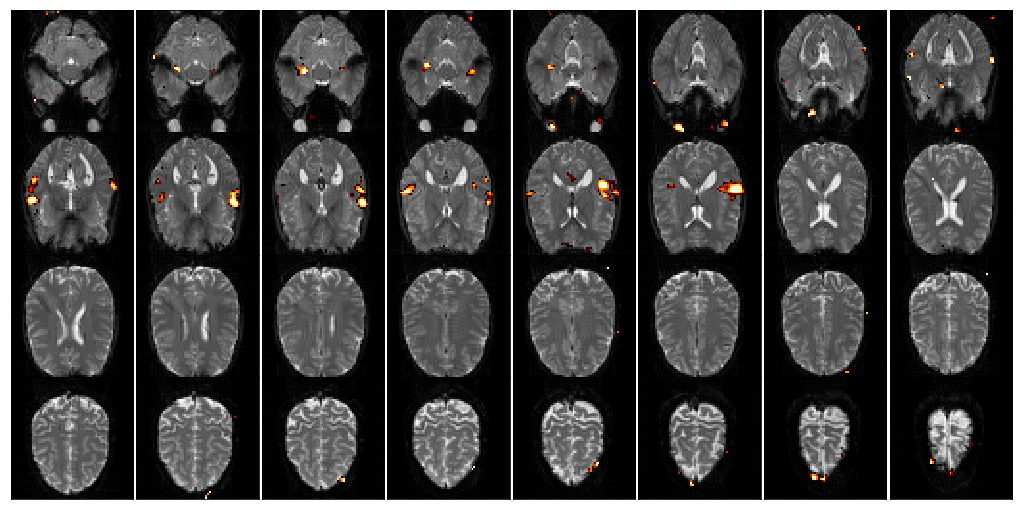

In [40]:
files = os.listdir('.\data')

n=0
m=0
fig, ax = plt.subplots(4, 8,figsize=(18, 9))
for i in files[23:55]:
    data = np.genfromtxt('data\{}'.format(i), delimiter=',')
    data_ordered = data.reshape(x_size,y_size,acq_num)
    mean_data = data_ordered.mean(axis=2)
    
    gaussian_kernel_array = gaussian_kernel(3)

    data_smoothed = np.zeros_like(data_ordered)
    for i in range(data_ordered.shape[2]):
        data_smoothed[:,:,i] = conv_image(data_ordered[:,:,i], gaussian_kernel_array)

    data_smoothed = data_smoothed.reshape(x_size * y_size, acq_num)
    beta, model, e, r = do_GLM(design_matrix, data_smoothed)
    
    r = r.reshape(x_size,y_size)
    map = r.copy()
    map[map<0.35] = np.nan

    #ax[n].set_title('Thresholded GLM activation map overlay')
    ax[n][m].set_xticks([])
    ax[n][m].set_yticks([])
    ax[n][m].imshow(mean_data, cmap='gray')
    ax[n][m].imshow(map, cmap='afmhot')
    
    if m==7:
        n +=1
        m = 0
    else:
        m +=1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

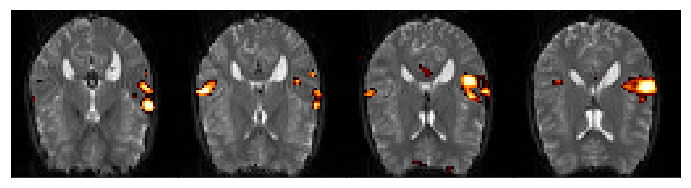

In [41]:
files = os.listdir('.\data')

n=0
m=0
fig, ax = plt.subplots(1, 4,figsize=(12, 6))
for i in files[33:37]:
    data = np.genfromtxt('data\{}'.format(i), delimiter=',')
    data_ordered = data.reshape(x_size,y_size,acq_num)
    mean_data = data_ordered.mean(axis=2)
    
    gaussian_kernel_array = gaussian_kernel(3)

    data_smoothed = np.zeros_like(data_ordered)
    for i in range(data_ordered.shape[2]):
        data_smoothed[:,:,i] = conv_image(data_ordered[:,:,i], gaussian_kernel_array)

    data_smoothed = data_smoothed.reshape(x_size * y_size, acq_num)
    beta, model, e, r = do_GLM(design_matrix, data_smoothed)
    
    r = r.reshape(x_size,y_size)
    map = r.copy()
    map[map<0.35] = np.nan
    
    if ax.ndim > 1:
        #ax[n].set_title('Thresholded GLM activation map overlay')
        ax[n][m].set_xticks([])
        ax[n][m].set_yticks([])
        ax[n][m].imshow(mean_data, cmap='gray')
        ax[n][m].imshow(map, cmap='afmhot')
    else:
        #ax[n].set_title('Thresholded GLM activation map overlay')
        ax[m].set_xticks([])
        ax[m].set_yticks([])
        ax[m].imshow(mean_data, cmap='gray')
        ax[m].imshow(map, cmap='afmhot')
    
    if m==3:
        n +=1
        m = 0
    else:
        m +=1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [119]:
ax.ndim

1